In [356]:
import numpy as np
from scipy import optimize

# training data
train_x = np.array(([3,5],[5,1],[10,2],[6,1.5]), dtype=float)
train_y = np.array(([75],[82],[93],[70]), dtype=float)

# testing data
test_x = np.array(([4, 5.5],[4.5, 1],[9,2.5],[6,2]), dtype=float)
test_y = np.array(([70],[89],[85],[75]), dtype=float)

In [357]:
class FNN(object):
    
    def __init__(self, learning_rate=0):
        # define hyperparameters
        self.input_layer_size = 2
        self.hidden_layer_size = 3
        self.output_layer_size = 1
        
        # define parameters
        self.W1 = np.random.randn(self.input_layer_size, self.hidden_layer_size)
        self.W2 = np.random.randn(self.hidden_layer_size, self.output_layer_size)
        
        # regularizartion parameter
        self.learning_rate = learning_rate
        
    def forward(self, X):
        # forward propagation 
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        prediction = self.sigmoid(self.z3)
        return prediction
    
    # define activation function
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_prime(self, z):
        return np.exp(-z) / ((1 + np.exp(-z))**2)
    
    # backprop
    def cost_function(self, X, desired_output):
        self.prediction = self.forward(X)
        total_error = ((1/2) * sum((desired_output - self.prediction)**2)) / X.shape[0] + \
                      (self.learning_rate / 2) * (np.sum(self.W1**2) + np.sum(self.W2**2))
                    
        return total_error
    
    def cost_function_prime(self, X, desired_y):
        self.prediction = self.forward(X)
        
        # layer 3 backpropgation error
        l3_backprop_error   = np.multiply(-(desired_y - self.prediction), self.sigmoid_prime(self.z3))
        cost_in_terms_of_W2 = np.dot(self.a2.T, l3_backprop_error) / X.shape[0] + (self.learning_rate * self.W2)
                
        # layer 2 backpropation error
        l2_backprop_error   = np.dot(l3_backprop_error, self.W2.T) * self.sigmoid_prime(self.z2)
        cost_in_terms_of_W1 = np.dot(X.T, l2_backprop_error) / X.shape[0] + (self.learning_rate * self.W1)
        
        return cost_in_terms_of_W1, cost_in_terms_of_W2
    
    # scale the data making sure its all the same
    def normalize_data(self, study_hours, test_scores):
        MAX_SCORE = 100.
        study_hours = study_hours / np.amax(study_hours, axis=0)
        test_scores /= MAX_SCORE
        return study_hours, test_scores
    
    # helper functions to interact with other classes and methods
    def get_params(self):
        # joins a sequence of flattened arrays from numpy.ndarray.ravel()
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def set_params(self, params):
        # set W1 and W2 using single parameter vector
        W1_start = 0
        W1_end   = self.hidden_layer_size * self.input_layer_size
        # reshape the W1 matrix
        self.W1  = np.reshape(params[W1_start : W1_end], (self.input_layer_size, self.hidden_layer_size))
        W2_end   = W1_end + (self.hidden_layer_size * self.output_layer_size)
        # reshape the W2 matrix
        self.W2  = np.reshape(params[W1_end : W2_end], (self.hidden_layer_size, self.output_layer_size))
        
    def compute_gradient(self, X, desired_y):
        cost_in_terms_of_W1, cost_in_terms_of_W2 = self.cost_function_prime(X, desired_y)
        
        # joins a sequence of flattened arrays from numpy.ndarray.ravel()
        return np.concatenate((cost_in_terms_of_W1.ravel(), cost_in_terms_of_W2.ravel()))
        
    # checking gradients with numerical gradient computation
    def compute_numerical_gradient(self, X, desired_y):
        
        # using epsilon addition and difference method 
        initial_params     = self.get_params()
        numerical_gradient = np.zeros(initial_params.shape)
        perturb            = np.zeros(initial_params.shape)
        e = 1e-4
        
        for i in range(len(initial_params)):
            # set perturbation vector
            perturb[i] = e
            self.set_params(initial_params + perturb)
            loss_2 = self.cost_function(X, desired_y)
            
            self.set_params(initial_params - perturb)
            loss_1 = self.cost_function(X, desired_y)
            
            # computer numerical gradient
            numerical_gradient[i] = (loss_2 - loss_1) / (2 * e)
            
            perturb[i] = 0
        
        self.set_params(initial_params)
        return numerical_gradient

In [358]:
NN = FNN(learning_rate=0.0001)

# normalize data
train_x, train_y = NN.normalize_data(train_x, train_y)
test_x, test_y = NN.normalize_data(text_x, test_y)

In [359]:
numerical_gradient = NN.compute_numerical_gradient(train_x, train_y)

In [360]:
gradient = NN.compute_gradient(train_x, train_y)

In [361]:
numerical_gradient

array([ 0.00734602,  0.00918773,  0.01675902,  0.00557791,  0.0058958 ,
        0.01273338, -0.03792651, -0.04371049, -0.01813184])

In [362]:
gradient

array([ 0.00734602,  0.00918773,  0.01675902,  0.00557791,  0.0058958 ,
        0.01273338, -0.03792651, -0.04371049, -0.01813184])

In [371]:
class Trainer(object):
    
    def __init__(self, Local_Ref):
        # make local reference to neural network
        self.Local_Ref = Local_Ref
        
    # cost function requries a wrapper due to ours being sophisticated
    def cost_function_wrapper(self, params, X, desired_y):
        self.Local_Ref.set_params(params)
        cost = self.Local_Ref.cost_function(X, desired_y)
        gradient = self.Local_Ref.compute_gradient(X, desired_y)
        return cost, gradient
    
    # track cost function value as training progresses
    def callback(self, params):
        self.Local_Ref.set_params(params)
        self.cost_list.append(self.Local_Ref.cost_function(self.X, self.desired_y))
        
    def train(self, train_x, train_y, test_x, test_y):
        
        self.train_x = train_x
        self.train_y = train_y
        
        self.cost_list = []
        self.test_cost_list = []
        
        initial_params = self.Local_Ref.get_params()
        
        options = {"maxiter": 200, "disp": True}
        _res = optimize.minimize(self.cost_function_wrapper, initial_params, jac=True, \
                                 method="BFGS", args=(train_x, train_y), options=options, \
                                 callback=self.callback)
        
        self.Local_Ref.set_params(_res.x)
        self.optimization_res = _res

In [372]:
T = Trainer(NN)

In [373]:
T.train(train_x, train_y, test_x, test_y)

Optimization terminated successfully.
         Current function value: 0.002619
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


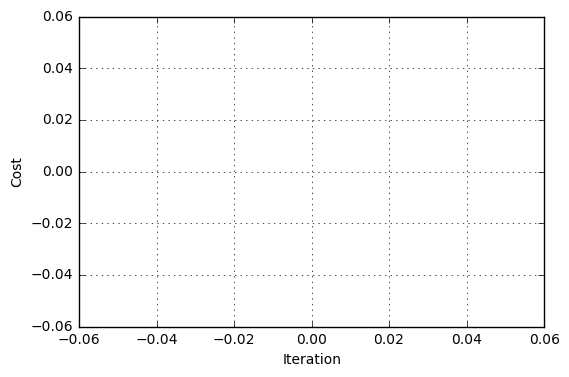

In [374]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(T.cost_list)
plt.plot(T.test_cost_list)
plt.grid(1)
plt.ylabel("Cost")
plt.xlabel("Iteration")

In [367]:
NN.cost_function_prime(train_x, train_y)

(array([[ -1.48827273e-06,  -5.03254322e-06,  -4.75876654e-07],
        [  6.70369836e-06,  -6.69375742e-07,  -1.93221210e-06]]),
 array([[  9.82850259e-06],
        [ -8.59524830e-06],
        [ -2.95679303e-06]]))

In [368]:
predictions = NN.forward(train_x)
for i in range(len(predictions)):
    print(int(predictions[i] * 100), "/100 marks", sep="")

74/100 marks
78/100 marks
85/100 marks
80/100 marks


In [369]:
train_y

array([[ 0.75],
       [ 0.82],
       [ 0.93],
       [ 0.7 ]])

In [370]:
# accounting for the noise (ambiguity) in the data set
# this is done using regularization

$\eta = \sum \frac{1}{2} (y - \hat{y})^{2}$